In [1]:
%load_ext autoreload
%autoreload 2
from RTKToArrayConversion import *
from ExtendedConeBeamDCC import *
from TextFileSaving import * 

In [2]:
filesdir_ref = "/home/mmouchet/Documents/SIEMENSDATA/GO.SIM/3D_patients/CF82/donneesBrutes/respi_libre/"
# reading projections
proj = itk.imread(filesdir_ref+"corrected_proj.mha")
# Reading the geometry of the scanner
xmlreader = rtk.ThreeDCircularProjectionGeometryXMLFileReader.New()
xmlreader.SetFilename(filesdir_ref+'geometry.xml')
# xmlreader.SetFilename(filesdir_ref+"geometry.xml")
xmlreader.GenerateOutputInformation()
geometry = xmlreader.GetOutputObject()
print('nproj = %d'%(len(geometry.GetGantryAngles())))
print(proj.GetLargestPossibleRegion().GetSize())

nproj = 49220
itkSize3 ([920, 32, 49220])


In [3]:
#Convert to array for faster computation
geometry_array = RTKtoNP(geometry)
proj_array = itk.GetArrayFromImage(proj)
proj_infos = GetProjectionInformations(proj)
source_pos_array = GetSourcePositions(geometry)
rotation_matrices_array = GetRotationMatrices(geometry)
fixed_matrices_array = GetFixedSystemMatrices(geometry)
print(proj_infos)

[array([1.02806101, 1.0947541 , 1.        ]), array([0., 0., 0.]), array([  920,    32, 49220]), array([[ 1.,  0.,  0.],
       [ 0., -1.,  0.],
       [ 0.,  0.,  1.]])]


In [4]:
first_idx = np.where(geometry_array[8,:]>140)[0][-1]
last_idx = np.where(geometry_array[8,:]>-140)[0][-1]
print(first_idx, last_idx)
T_rot = 0.5 #s
T_step = 0.1 #s
idx_proj_ref = np.arange(first_idx, last_idx, int((T_step*1536)//0.5))
print(idx_proj_ref,len(idx_proj_ref))
axial_limit =  int(1536*np.round((1-1/32)/0.8))//2
print(axial_limit)

18055 46156
[18055 18362 18669 18976 19283 19590 19897 20204 20511 20818 21125 21432
 21739 22046 22353 22660 22967 23274 23581 23888 24195 24502 24809 25116
 25423 25730 26037 26344 26651 26958 27265 27572 27879 28186 28493 28800
 29107 29414 29721 30028 30335 30642 30949 31256 31563 31870 32177 32484
 32791 33098 33405 33712 34019 34326 34633 34940 35247 35554 35861 36168
 36475 36782 37089 37396 37703 38010 38317 38624 38931 39238 39545 39852
 40159 40466 40773 41080 41387 41694 42001 42308 42615 42922 43229 43536
 43843 44150 44457 44764 45071 45378 45685 45992] 92
768


In [5]:
from tqdm import tqdm_notebook
res = []
for ref in tqdm_notebook(idx_proj_ref):
    res_temp = []
    for i in range(-axial_limit, axial_limit):
        if ref == i + ref or i + ref < 0 or i + ref >= len(geometry.GetGantryAngles()):
            pass
        else:
            r = ComputeDCCsForOnePair(ref, i + ref, geometry_array, source_pos_array, rotation_matrices_array, fixed_matrices_array, proj_array, proj_infos)
            if r !=0 :
                res_temp.append(r)
    res.append(np.mean(res_temp))

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


invalid value encountered in double_scalars
invalid value encountered in double_scalars


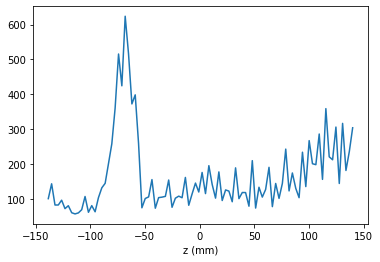

In [6]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(geometry_array[8,idx_proj_ref], res)
plt.xlabel("z (mm)")
plt.show()

In [7]:
## save res
import csv
def WriteErrorFile(FileName, abs, res):
    with open(FileName, 'w') as csvfile:
        fieldnames = ['abs','err']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i in range(len(res)):
            writer.writerow({'abs': abs[i],'err': res[i]})
    return 0


WriteErrorFile(filesdir_ref+"140_n140_Hann_Wover50.csv", geometry_array[8,idx_proj_ref], res)


0